In [5]:
# standard libraries
import importlib
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy import linalg, stats, optimize
import time
import sys
sys.path.append('/Users/francescacrucinio/Documents/MD_LVM')

# modules from particles
import particles  # core module
from particles import smc_samplers as ssp
from particles import distributions as dists  # where probability distributions are defined
from particles import resampling as rs

import pgd
import md_lvm
importlib.reload(pgd)
importlib.reload(md_lvm)

<module 'md_lvm' from '/Users/francescacrucinio/Documents/MD_LVM/md_lvm.py'>

In [2]:
# Generate data
D = 3
theta = np.array([2, 3, 4])
sigma = 0.1
x = theta+np.random.normal(scale = sigma)

ndata = 900
f = 2*np.random.uniform(size = (ndata, theta.size))-1
p = 1/(1+np.exp(-np.matmul(f, x)))
y = np.random.binomial(1, p)

In [6]:
N = 10
K = 3000
gamma = 0.001

th0 = np.matrix([0, 0, 0]).T  # Initial parameter guess.
X0 = np.random.normal(size = (D, N))  # Initial particle cloud.

In [7]:
th_pgd, X_pgd = pgd.pgd_blr(np.matrix(y).T, f, gamma, K, N, th0, X0, sigma)
th_ipla, X_ipla = pgd.ipla_blr(np.matrix(y).T, f, gamma, K, N, th0, X0, sigma)
th_md, X_md, W_md = md_lvm.md_toy_bayesian_lr_fast((y, gamma, K, N, th0, X0, f, sigma)

(-30.0, 3000.0)

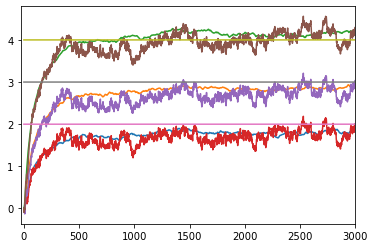

In [8]:
plt.plot(th_pgd[0, :].T, label='PGD')
plt.plot(th_pgd[1, :].T, label='PGD')
plt.plot(th_pgd[2, :].T, label='PGD')
plt.plot(th_ipla[0, :].T, label='IPLA')
plt.plot(th_ipla[1, :].T, label='IPLA')
plt.plot(th_ipla[2, :].T, label='IPLA')
plt.plot(th_md[0, :].T, label='SMC')
plt.plot(th_md[1, :].T, label='SMC')
plt.plot(th_md[2, :].T, label='SMC')
plt.plot(2*np.ones(K), label='Optimal theta')
plt.plot(3*np.ones(K), label='Optimal theta')
plt.plot(4*np.ones(K), label='Optimal theta')
plt.xlim([-K/100, K])
# plt.legend(loc='lower right')

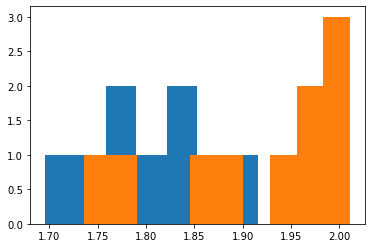

In [9]:
plt.hist(X_pgd[0, -N:].T);
plt.hist(X_ipla[0, -N:].T);

In [ ]:
def rwm_accept_bayesian_lr(v, prop, theta_seq, gamma, data, f):
    n = theta_seq.shape[0]
    log_acceptance = 0.5*((1-gamma)**n)*np.sum(v**2 - prop**2, axis = 0)
    for k in range(n):
        log_acceptance = log_acceptance + gamma*(1-gamma)**(n-k-2)*(ll_bayesian_lr(theta_seq[k, :], prop, data, f) - ll_bayesian_lr(theta_seq[k, :], v, data, f))
    accepted = np.log(np.random.uniform(size = v.shape[1])) <= log_acceptance
    output = ssp.view_2d_array(v)
    output[:, accepted] = prop[:, accepted]
    return output

In [ ]:
N = 10
K = 1000
gamma = 0.01

th0 = np.matrix([0, 0, 0]).T  # Initial parameter guess.
X0 = np.random.normal(size = (D, N))  # Initial particle cloud.

In [ ]:
X_md = np.zeros((K, D, N))
th_md = np.zeros((K, D))
X_md[0, :, :] = X0
W = np.ones(N)/N

In [ ]:
for n in range(1, K):
    th_md[n, :] = th_md[n-1, :] + gamma*(np.sum(X_md[n-1, :, :]*W, axis = 1)-th_md[n-1, :])/sigma**2
    if (n > 1):
        # resample
        ancestors = rs.resampling('stratified', W)
        X_md[n-1, :, :] = X_md[n-1, :, ancestors].T
    # MCMC move
    prop = rwm_proposal(X_md[n-1, :, :].T, W).T
    X_md[n, :, :] = rwm_accept_bayesian_lr(X_md[n-1, :, :], prop, th_md[:n, :], gamma, y, f)
    # reweight
    logW = ll_bayesian_lr(th_md[n, :], X_md[n, :, :], y, f) + 0.5*((1-gamma)**(n-1))*np.sum(X_md[n, :, :]**2, axis = 0)
    for k in range(n-1):
        logW = logW - gamma*((1-gamma)**(n-k-2))*ll_bayesian_lr(th_md[k, :], X_md[n, :, :], y, f)
    logW = gamma*logW
    W = rs.exp_and_normalise(logW)

In [ ]:
plt.plot(th_md[:, 0], label='PGD')
plt.plot(th_md[:, 1], label='PGD')
plt.plot(th_md[:, 2], label='PGD')
plt.plot(2*np.ones(K), label='Optimal theta')
plt.plot(3*np.ones(K), label='Optimal theta')
plt.plot(4*np.ones(K), label='Optimal theta')
plt.xlim([-K/100, K])
plt.legend(loc='upper right')

In [ ]:
np.mean(th_md[500:1000, :], axis = 0)

In [ ]:
n

In [ ]:
for n in range(1, K):
    th_md[n, :] = th_md[n-1, :] + gamma*(np.sum(X_md[n-1, :, :]*W, axis = 1)-th_md[n-1, :])/sigma**2
    if (n > 1):
        # resample
        ancestors = rs.resampling('stratified', W)
        X_md[n-1, :, :] = X_md[n-1, :, ancestors].T
    # MCMC move
    prop = rwm_proposal(X_md[n-1, :, :].T, W).T
    X_md[n, :, :] = rwm_accept_bayesian_lr2(X_md[n-1, :, :], prop, th_md[:n, :], gamma, y, f)
    # reweight
    logW = (1-gamma)**(n-1)*(ll_bayesian_lr(th_md[n, :], X_md[n, :, :], y, f) + 0.5*np.sum(X_md[n, :, :]**2, axis = 0))
    logW = gamma*logW
    W = rs.exp_and_normalise(logW)